<a href="https://colab.research.google.com/github/nemo0001/Python/blob/master/cardio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
#getting the data from PC

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving cardio_train.csv to cardio_train (2).csv
User uploaded file "cardio_train.csv" with length 2941524 bytes


In [49]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop,Nadam,Adadelta,Adam
from tensorflow.keras.layers import BatchNormalization,LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import seaborn as sns
import scipy.stats as stats
import sklearn
import os

from sklearn.metrics import roc_curve, roc_auc_score,precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt


In [50]:
data_raw=pd.read_csv("cardio_train.csv",sep=";")
data_raw.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [51]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [52]:
data_raw.drop("id",axis=1,inplace=True)

In [53]:
#handling duplicate values
print("There is {} duplicated values in data frame".format(data_raw.duplicated().sum()))

There is 24 duplicated values in data frame


In [54]:
#We can drop the duplicates because they have no effect on training of model.
#Firstly let us see the duplicated rows with eyes.
duplicated = data_raw[data_raw.duplicated(keep=False)]
duplicated = duplicated.sort_values(by=['age', "gender", "height"], ascending= False) 
# I sorted the values to see duplication clearly

duplicated.head(2) # Show us just 1 duplication of 24

#duplicated() method helps in analyzing duplicate values only. 
#It returns a boolean series which is True only for Unique elements.

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
2677,22077,1,175,69.0,120,80,1,1,0,0,1,1
45748,22077,1,175,69.0,120,80,1,1,0,0,1,1


In [55]:
data_raw.drop_duplicates(inplace=True)
#Return DataFrame with duplicate rows removed, optionally only considering certain columns.
#keep : {‘first’, ‘last’, False}, default ‘first’

print("There is {} duplicated values in data frame".format(data_raw.duplicated().sum()))

There is 0 duplicated values in data frame


In [56]:
print("There is {} missing values in data frame".format(data_raw.isnull().sum().sum()))

There is 0 missing values in data frame


In [57]:
#VISUALIZATION
#Detecting Outliers 
#Detecting outlier and handling them can increase our accuracy score.
x = data_raw.copy(deep=True)
x.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,19468.950126,1.349648,164.359152,74.208519,128.820453,96.636261,1.366997,1.226535,0.088159,0.053790,0.803718,0.499771
std,2467.374620,0.476862,8.211218,14.397211,154.037729,188.504581,0.680333,0.572353,0.283528,0.225604,0.397187,0.500004
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [58]:
#Columns of "age", "height", "weight", "ap_hi", "ap_lo" may have outlier.
#In order to compare them on same scale we need to standardize firstly.
#My Standard Scalar Function
s_list = ["age", "height", "weight", "ap_hi", "ap_lo"]
def standartization(x):
    x_std = x.copy(deep=True)
    for column in s_list:
        x_std[column] = (x_std[column]-x_std[column].mean())/x_std[column].std()
    return x_std 
x_std=standartization(x)
x_std.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,-0.436071,2,0.443399,-0.847978,-0.122181,-0.088254,1,1,0,0,1,0
1,0.307635,1,-1.018016,0.749554,0.072577,-0.035205,3,1,0,0,1,1
2,-0.248017,1,0.078045,-0.709062,0.007658,-0.141303,3,1,0,0,0,1
3,-0.748143,2,0.565184,0.541180,0.137496,0.017844,1,1,0,0,1,1
4,-0.808532,1,-1.018016,-1.264725,-0.187100,-0.194352,1,1,0,0,0,0


In [59]:
#Visualization
#In order to use the multi box graph plot we need to melt out data.
x_melted = pd.melt(frame=x_std, id_vars="cardio", value_vars=s_list, var_name="features", value_name="value", col_level=None)
x_melted

#melt() function is useful to massage a DataFrame into a format where one or more columns are identifier variables, while all other columns, 
#considered measured variables, are unpivoted to the row axis, leaving just two non-identifier columns, variable and value.

,cardio,features,value
0,0,age,-0.436071
1,1,age,0.307635
2,1,age,-0.248017
3,1,age,-0.748143
4,0,age,-0.808532
...,...,...,...
349875,0,ap_lo,-0.088254
349876,1,ap_lo,-0.035205
349877,1,ap_lo,-0.035205
349878,1,ap_lo,-0.088254


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

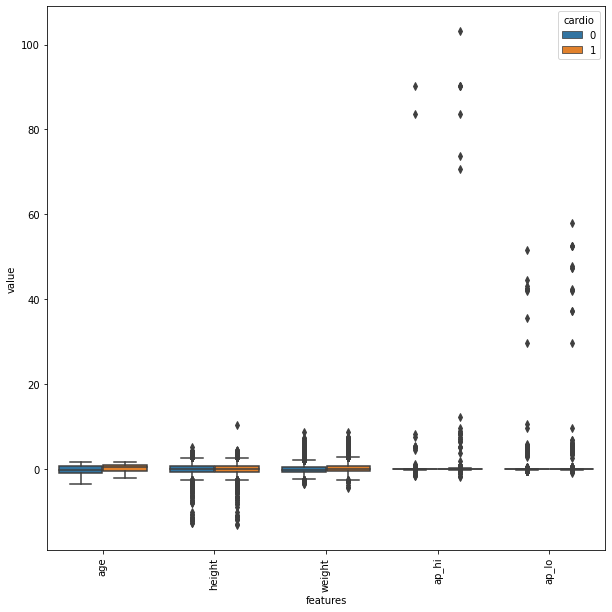

In [60]:
plt.figure(figsize=(10,10))
sns.boxplot(x="features", y="value", hue="cardio", data=x_melted)
plt.xticks(rotation=90)

In [61]:
#There are some outliers in the dataset, but as seen above there is an unusual outlier in ap_hi and ap_lo features.
#Let us calculate the low bound and hi bound of ap_lo and ap_hi features
ap_list = ["ap_hi", "ap_lo","height","weight"]
boundary = pd.DataFrame(index=["lower_bound","upper_bound"]) # We created an empty dataframe
for each in ap_list:
    Q1 = x[each].quantile(0.25)
    Q3 = x[each].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1- 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    boundary[each] = [lower_bound, upper_bound ]
boundary

,ap_hi,ap_lo,height,weight
lower_bound,90.0,65.0,142.5,39.5
upper_bound,170.0,105.0,186.5,107.5


In [62]:
#We can select the index of outlier data by using boundaries we calculated.
#Normally we should analyze both upper outliers and below outliers but in this case, I consider to handle 
#just uppers because of their extremely higher values.
ap_hi_filter = (x["ap_hi"] > boundary["ap_hi"][1])
ap_lo_filter = (x["ap_lo"] > boundary["ap_lo"][1])                                                           
outlier_filter = (ap_hi_filter | ap_lo_filter)
x_outliers = x[outlier_filter]
x_outliers["cardio"].value_counts()

1    2025
0     388
Name: cardio, dtype: int64

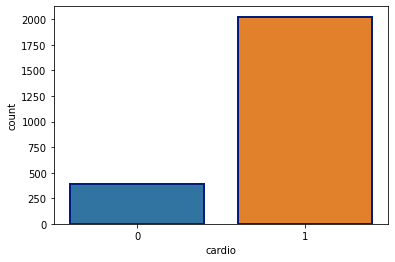

In [63]:
#Cardiovascular disease is present in 83 percent of the ap_hi and ap_lo outlier data,
#Because of ap_hi and ap_lo symbolizes high blood pressure, the high rate of disease is consistent with real life.
#For this reason, I decided to drop just medically impossible data from the dataset.
#And I have dropped some of data because we have sufficent data (70000) otherwise I would try to handle them by assigning new values.
sns.countplot(x='cardio',data=x_outliers,linewidth=2,edgecolor=sns.color_palette("dark", 1))

In [64]:
#A study published by doctors in NCBI NLM recorded a maximum blood pressure of 370/360 mm Hg. This study was performed by recording blood pressure in 10 male athletes through radial artery catheterization.
#Thus we can drop the ap_hi outlier values over 250 and ap_lo outlier values over 200, without fear of missing data.
out_filter_bp = ((x["ap_hi"]>250) | (x["ap_lo"]>200) )
print("There is {} outlier".format(x[out_filter_bp]["cardio"].count()))

#We remove lower and higher outliers for height and weight
ht_filter = (x["height"] > boundary["height"][1])
ht_filter_l = (x["height"] < boundary["height"][0])
wt_filter = (x["weight"] > boundary["weight"][1])
wt_filter_l = (x["weight"] < boundary["weight"][0])                                                           
outlier_filter_hw = (ht_filter | wt_filter|ht_filter_l|wt_filter_l)
x_outliers_hw = x[outlier_filter_hw]
x_outliers_hw["cardio"].value_counts()

out_filter_h = ((x["height"] > boundary["height"][1]) | (x["height"] < boundary["height"][0]))
out_filter_w = ((x["weight"] > boundary["weight"][1]) | (x["weight"] < boundary["weight"][0]))
print("There is {} outlier".format(x[out_filter_h]["cardio"].count()))
print("There is {} outlier".format(x[out_filter_w]["cardio"].count()))


There is 993 outlier
There is 519 outlier
There is 1819 outlier


In [65]:
x = x[~out_filter_bp]
x=x[~out_filter_h]
x=x[~out_filter_w]

#Higher diastolic than systolic blood pressure is impossible, too. So let's remove these.
x.drop(x[x["ap_lo"] > x["ap_hi"]].index, inplace=True)
x.drop(x[x["ap_lo"] <= 30].index, inplace=True)
x.drop(x[x["ap_hi"] <= 40].index, inplace=True)
x.drop(x[x["ap_lo"] >= 200].index, inplace=True)
x.drop(x[x["ap_hi"] >= 250].index, inplace=True)

x.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


(66459, 12)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
age,1.000000,-0.021335,-0.085890,0.068481,0.213281,0.160724,0.157028,0.098836,-0.044958,-0.027551,-0.011062,0.243087
gender,-0.021335,1.000000,0.519479,0.162291,0.061069,0.065718,-0.038693,-0.022920,0.339302,0.170253,0.007178,0.004527
height,-0.085890,0.519479,1.000000,0.310426,0.009114,0.027818,-0.064388,-0.026080,0.193968,0.094535,-0.007460,-0.019020
weight,0.068481,0.162291,0.310426,1.000000,0.255413,0.242734,0.130159,0.091228,0.063305,0.064226,-0.015015,0.175799
ap_hi,0.213281,0.061069,0.009114,0.255413,1.000000,0.733157,0.193048,0.087781,0.025061,0.032222,0.000865,0.428567
ap_lo,0.160724,0.065718,0.027818,0.242734,0.733157,1.000000,0.158147,0.069367,0.023605,0.034183,0.000738,0.338930
cholesterol,0.157028,-0.038693,-0.064388,0.130159,0.193048,0.158147,1.000000,0.449185,0.006794,0.033367,0.009425,0.220301
gluc,0.098836,-0.022920,-0.026080,0.091228,0.087781,0.069367,0.449185,1.000000,-0.009974,0.006446,-0.007052,0.088919
smoke,-0.044958,0.339302,0.193968,0.063305,0.025061,0.023605,0.006794,-0.009974,1.000000,0.341654,0.028331,-0.019440
alco,-0.027551,0.170253,0.094535,0.064226,0.032222,0.034183,0.033367,0.006446,0.341654,1.000000,0.026696,-0.010534


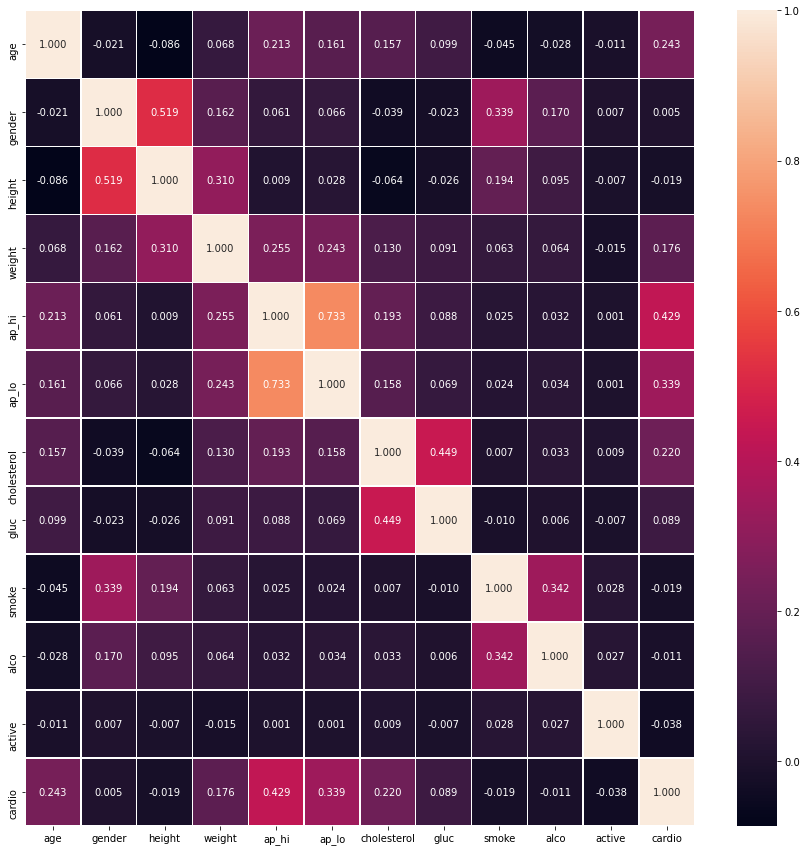

In [66]:

corr = x.corr()
f, ax = plt.subplots(figsize = (15,15))
sns.heatmap(corr, annot=True, fmt=".3f", linewidths=0.5, ax=ax)
corr

#We can see from correlation map easily; cholesterol, blood pressure (ap_hi and ap_low both) and age have a powerful relationship with cardiovascular diseases.
#Glucogen and cholesterol have a strong relationship among them either.

In [67]:
#Calculating BMI
def bmi_calc(w, h):
    return w/(h**2)
x["bmi"] = x["weight"]/ (x["height"]/100)**2

x.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177


In [68]:
#gender detection
a = x[x["gender"]==1]["height"].mean()
b = x[x["gender"]==2]["height"].mean()
if a > b:
    gender = "male"
    gender2 = "female"
else:
    gender = "female"
    gender2 = "male"
print("Gender:1 is "+ gender +" & Gender:2 is " + gender2)

#We did not change other categorical code to one hot encoding because they express really hierarchical size
#An example from describtion of dataset : Cholesterol | 1: normal, 2: above normal, 3: well above normal

Gender:1 is female & Gender:2 is male


In [69]:
x["gender"] = x["gender"] % 2

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

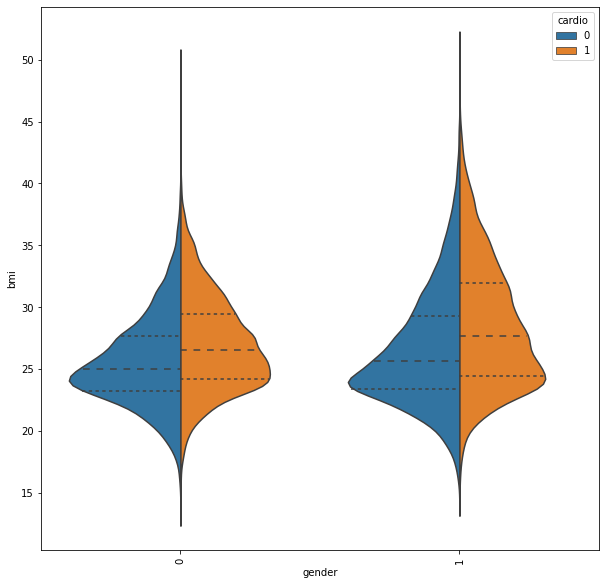

In [70]:
from sklearn.preprocessing import StandardScaler
x_std = standartization(x)

data = pd.melt(x_std,id_vars="cardio",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="gender", y="bmi", hue="cardio", data=x,split=True, inner="quart")
plt.xticks(rotation=90)
#If we interpret the violin plot, the median and quartiles of bmi distribution of patients is slightly higher than non-patients.

In [71]:
y = x["cardio"]
y.shape
x.drop("cardio", axis=1,inplace=True)
x.head()

#To check if we have the same percentage of people with CVD in our data.
#Since it's uniform we won't use stratify option in train_test split
sum(y)/len(y)

0.489805744895349

In [72]:
#train-test split
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)
#sum(y_train)/len(y_train)
#sum(y_test)/len(y_test)


Decision tree
Accuracy Score 0.6308305747818237
Confusion Matrix: 
 [[4328 2471]
 [2436 4057]]
AUC Score 0.6306954685515919


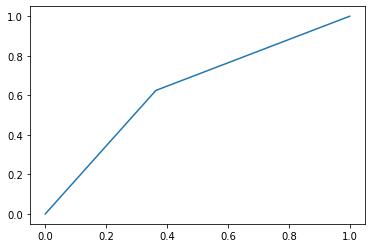

Random forest
Accuracy Score 0.7181011134517002
Confusion Matrix: 
 [[5054 1745]
 [2002 4491]]
AUC Score 0.7175062798007524


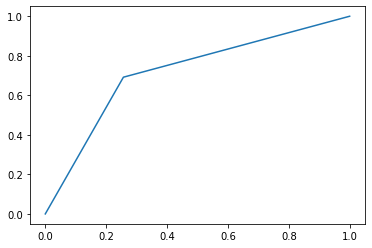

KNN
Accuracy Score 0.7156184170929882
Confusion Matrix: 
 [[5355 1444]
 [2336 4157]]
AUC Score 0.7139218818179451


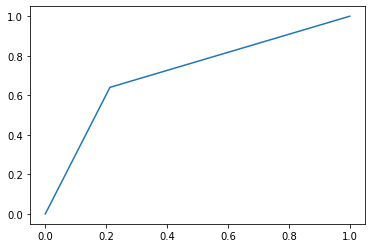

SVM
Accuracy Score 0.5115106831176648
Confusion Matrix: 
 [[6799    0]
 [6493    0]]
AUC Score 0.5


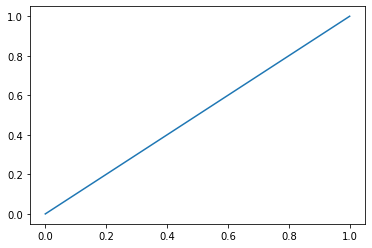

Naive bayes
Accuracy Score 0.6539271742401445
Confusion Matrix: 
 [[5065 1734]
 [2866 3627]]
AUC Score 0.6517820327035075


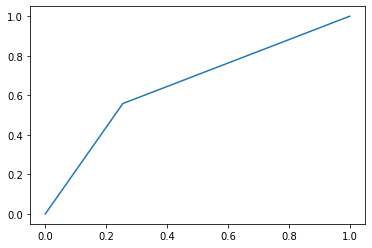

Logistic Regression
Accuracy Score 0.5115106831176648
Confusion Matrix: 
 [[6799    0]
 [6493    0]]
AUC Score 0.5


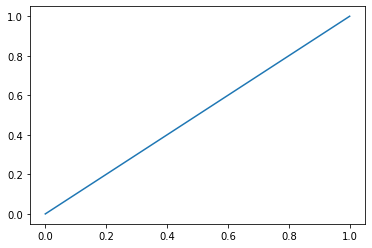

In [73]:
#Normalization
from sklearn.preprocessing import normalize
x_train = normalize(x_train)
x_test = normalize(x_test)
x = normalize(x)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

dec = DecisionTreeClassifier()
ran = RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=100)
svm = SVC(random_state=1)
naive = GaussianNB()
logreg = LogisticRegression(solver="liblinear", max_iter=200)

#models to be fitted
#later part added AUC scores and plots for better evaluation
models = {"Decision tree" : dec,
          "Random forest" : ran,
          "KNN" : knn,
          "SVM" : svm,
          "Naive bayes" : naive,
          "Logistic Regression" : logreg}
scores= { }
auc={ }

for key, value in models.items():    
    model = value
    model.fit(x_train, y_train)
    scores[key] = model.score(x_test, y_test)
    print(key)
    print("Accuracy Score", scores[key])

    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred.round())
    print("Confusion Matrix:", "\n", cm)

    tpr, fpr, threshold = roc_curve(y_test, y_pred)
    auc[key] = roc_auc_score(y_test, y_pred)
    print("AUC Score", auc[key])

    plt.plot(tpr, fpr)
    plt.show()

In [74]:
scores

{'Decision tree': 0.6308305747818237,
 'KNN': 0.7156184170929882,
 'Logistic Regression': 0.5115106831176648,
 'Naive bayes': 0.6539271742401445,
 'Random forest': 0.7181011134517002,
 'SVM': 0.5115106831176648}

In [75]:
auc

{'Decision tree': 0.6306954685515919,
 'KNN': 0.7139218818179451,
 'Logistic Regression': 0.5,
 'Naive bayes': 0.6517820327035075,
 'Random forest': 0.7175062798007524,
 'SVM': 0.5}

In [76]:
scores_frame = pd.DataFrame(scores, index=["Accuracy Score"]).T
scores_frame.sort_values(by=["Accuracy Score"], axis=0 ,ascending=False, inplace=True)
scores_frame

,Accuracy Score
Random forest,0.718101
KNN,0.715618
Naive bayes,0.653927
Decision tree,0.630831
SVM,0.511511
Logistic Regression,0.511511


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

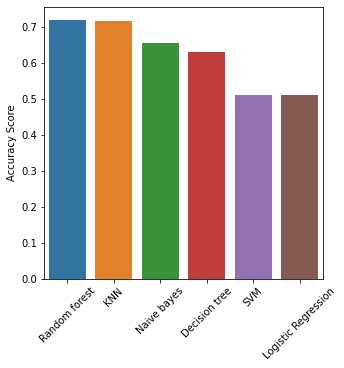

In [77]:
plt.figure(figsize=(5,5))
sns.barplot(x=scores_frame.index,y=scores_frame["Accuracy Score"])
plt.xticks(rotation=45) 
# Rotation of model names...

In [78]:
#K Fold Cross Validation
#With K-Fold cross-validation, we obtain "K" pieces of results from different mini-training sets from our main training set.
#Then we choose the average of these results as the actual result.
#After all, by taking the standard deviation of K result, we can examine whether the data is consistent.
from sklearn.model_selection import cross_val_score
accuracies_log_reg = cross_val_score(estimator=logreg, X=x_train, y=y_train, cv=10)
accuracies_random_forest = cross_val_score(estimator=ran, X=x_train, y=y_train, cv=10)
accuracies_knn = cross_val_score(estimator=knn, X=x_train, y=y_train, cv=10)


In [79]:
print("Random Forest Average accuracy: ", accuracies_random_forest.mean())
print("Random Forest Standard Deviation: ", accuracies_random_forest.std())
print("KNN Average accuracy: ", accuracies_knn.mean())
print("KNN Standard Deviation: ", accuracies_knn.std())
print("Logistic Regression Average accuracy: ", accuracies_log_reg.mean())
print("Logistic Regression Standard Deviation: ", accuracies_log_reg.std())

Random Forest Average accuracy:  0.7148231753197892
Random Forest Standard Deviation:  0.007557305934232101
KNN Average accuracy:  0.71493599968187
KNN Standard Deviation:  0.005567796940120195
Logistic Regression Average accuracy:  0.5098651407463574
Logistic Regression Standard Deviation:  5.041570321177908e-05


In [80]:
#Let us use grid search algorithm, in order to find the best 
#Random Forest Algorithm's "n_estimators" hyperparameter value for our model, l
# grid search cross validation with 1 hyperparameter
from sklearn.model_selection import GridSearchCV 

grid = {"n_estimators" : np.arange(10,150,10)}

ran_cv = GridSearchCV(ran, grid, cv=3) # GridSearchCV
ran_cv.fit(x_train,y_train)# Fit

# Print hyperparameter
print("Tuned hyperparameter n_estimators: {}".format(ran_cv.best_params_)) 
print("Best score: {}".format(ran_cv.best_score_))


Tuned hyperparameter n_estimators: {'n_estimators': 100}
Best score: 0.714936026356977


Test accuracy:  0.7182515798976828
Confusion Matrix: 
 [[5032 1767]
 [1978 4515]]
AUC Score 0.7177365389729109


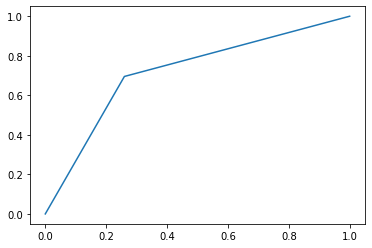

In [85]:
#Test Set Accuracy Score for Random forest¶
#Now we have selected our model with better hyper parameters than default ones.
#It is time to evaluate model with our test set
ran_best = RandomForestClassifier(n_estimators=140)
ran_best.fit(x_train, y_train)
print("Test accuracy: ",ran_best.score(x_test, y_test))

y_pred = ran_best.predict(x_test)
cm = confusion_matrix(y_test, y_pred.round())
print("Confusion Matrix:", "\n", cm)

tpr, fpr, threshold = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print("AUC Score", auc)

plt.plot(tpr, fpr)
plt.show()

In [83]:
#Later we moved log_reg to above classification method to maintain Choronological order
#log_reg = LogisticRegression(solver="liblinear", max_iter=200)
grid = {"penalty" : ["l1", "l2"],
         "C" : np.arange(60,80,2)} # (60,62,64 ... 78)
log_reg_cv = GridSearchCV(logreg, grid, cv=3)
log_reg_cv.fit(x_train, y_train)

# Print hyperparameter
print("Tuned hyperparameter n_estimators: {}".format(log_reg_cv.best_params_)) 
print("Best score: {}".format(log_reg_cv.best_score_))

Tuned hyperparameter n_estimators: {'C': 66, 'penalty': 'l1'}
Best score: 0.7250926547403876


Test accuracy:  0.7295365633463737
Confusion Matrix: 
 [[5352 1447]
 [2148 4345]]
AUC Score 0.7281783903545124


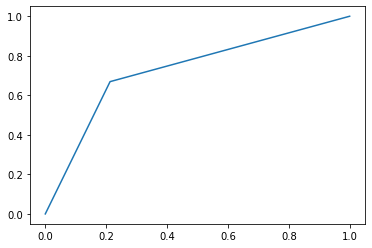

In [86]:
#Test Set Accuracy Score ¶
#Now we have selected our model with better hyper parameters than default ones.
#It is time to evaluate model with our test set
logreg_best = LogisticRegression(C=74, penalty="l1", solver="liblinear")
logreg_best.fit(x_train, y_train)
print("Test accuracy: ",logreg_best.score(x_test, y_test))

y_pred = logreg_best.predict(x_test)
cm = confusion_matrix(y_test, y_pred.round())
print("Confusion Matrix:", "\n", cm)

tpr, fpr, threshold = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print("AUC Score", auc)

plt.plot(tpr, fpr)
plt.show()

In [ ]:
y_true = y_test
#y_pred = logreg_best.predict(x_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm,fmt=".0f", annot=True,linewidths=0.2, linecolor="purple", ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Grand Truth")
plt.show()

In [ ]:
TN = cm[0,0]
TP = cm[1,1]
FN = cm[1,0]
FP = cm[0,1]
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
F1_Score = 2*(Recall * Precision) / (Recall + Precision)
pd.DataFrame([[Precision, Recall, F1_Score]],columns=["Precision", "Recall", "F1 Score"], index=["Results"])
#High precision relates to the low false positive rate
#High recall relates to the low false negative rate


In [ ]:
# #Optimising upon lowering false negatives i.e. improving recall.
# from sklearn.model_selection import StratifiedKFold

# #The scorers dictionary can be used as the scoring argument in GridSearchCV. 
# #When multiple scores are passed, GridSearchCV.cv_results_ will return scoring metrics for each of the score types provided.
# scorers = {
#     'precision_score': make_scorer(precision_score),
#     'recall_score': make_scorer(recall_score),
#     'accuracy_score': make_scorer(accuracy_score)
# }

# #random forests have many tunable parameters, which make it suitable for GridSearchCV
# param_grid = {
#     'min_samples_split': [3, 5, 10], 
#     'n_estimators' : [100, 300],
#     'max_depth': [3, 5, 15, 25],
#     'max_features': [3, 5, 10, 20]
# }

# #The function below uses GridSearchCV to fit several classifiers according to the combinations of parameters in the param_grid. 
# #The scores from scorers are recorded and the best model (as scored by the refit argument) will be selected and "refit" to the full training data for downstream use. 
# #This also makes predictions on the held out X_test and prints the confusion matrix to show performance.
# def grid_search_wrapper(refit_score='recall_score'):
#     """
#     fits a GridSearchCV classifier using refit_score for optimization
#     prints classifier performance metrics
#     """
#     skf = StratifiedKFold(n_splits=10)
#     grid_search = GridSearchCV(ran, param_grid, scoring=scorers, refit=refit_score,
#                            cv=skf, return_train_score=True, n_jobs=-1)
#     grid_search.fit(x_train, y_train)

#     # make the predictions
#     y_pred = grid_search.predict(x_test.values)

#     print('Best params for {}'.format(refit_score))
#     print(grid_search.best_params_)

#     # confusion matrix on the test data.
#     print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
#     print(pd.DataFrame(confusion_matrix(y_test, y_pred),
#                  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
#     return grid_search

# grid_search_clf = grid_search_wrapper(refit_score='recall_score')


In [ ]:
##ANN
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(6, input_dim=12, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
optimizer = RMSprop(learning_rate=0.002)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=optimizer)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau( 
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.1,       # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=50,        # The number of epochs with no improvement after which learning rate will be reduced.
    verbose=1,         # 0: quiet - 1: update messages.
    mode="auto",       # {auto, min, max}. In min mode, lr will be reduced when the quantity monitored has stopped decreasing; 
                       # in the max mode it will be reduced when the quantity monitored has stopped increasing; 
                       # in auto mode, the direction is automatically inferred from the name of the monitored quantity.
    min_delta=0.0001,  # threshold for measuring the new optimum, to only focus on significant changes.
    cooldown=0,        # number of epochs to wait before resuming normal operation after learning rate (lr) has been reduced.
    min_lr=0.00001     # lower bound on the learning rate.
    )

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=400, restore_best_weights=True)
history = model.fit(x=x_train, y=y_train.values,
                    batch_size=1024, epochs=1500,
                    verbose=0,validation_data=(x_test,y_test.values),
                    callbacks=[learning_rate_reduction, es],
                    shuffle=True)

model.evaluate(x_test, y_test.values, verbose=2)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

_______________________________________________________________________

In [87]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")


Train Result:
Accuracy Score: 73.65%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.722252      0.754103  0.736453      0.738177      0.737863
recall         0.784971      0.685982  0.736453      0.735477      0.736453
f1-score       0.752307      0.718431  0.736453      0.735369      0.735703
support    27108.000000  26059.000000  0.736453  53167.000000  53167.000000
_______________________________________________
Confusion Matrix: 
 [[21279  5829]
 [ 8183 17876]]

Test Result:
Accuracy Score: 73.34%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy     macro avg  weighted avg
precision     0.720776     0.749240  0.733449      0.735008      0.734680
recall        0.781733     0.682889  0.733449      0.732311      0.733449
f1-score      0.750018     0.714527  0.733449      0.732273      0.732681
support  

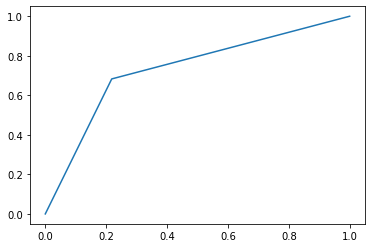

In [88]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
xgb_clf.fit(x_train, y_train)

print_score(xgb_clf, x_train, y_train, x_test, y_test, train=True)
print_score(xgb_clf, x_train, y_train, x_test, y_test, train=False)

y_pred = xgb_clf.predict(x_test)

tpr, fpr, threshold = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
print("AUC-score:", auc_score)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(tpr, fpr)
plt.show()

In [93]:
#Hyper-Parameter tuning using GridSearchCV
##Round 1
# param_grid= {
#     'max_depth' : [3,4,5],
#     'learning_rate': [0.1,0.01,0.05],
#     'gamma':[0,0.25,1.0],
#     'reg_lambda': [0,1.0,10.0]
# }
#Tuned hyperparameter n_estimators: {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 10.0}
#Best score: 0.7979720547889348

##Round 2
param_grid= {
    'max_depth' : [5,6,7],
    'learning_rate': [0.1,0.5,1],
    'gamma':[0.25],
    'reg_lambda': [10.0,20,100]
}
# Tuned hyperparameter n_estimators: {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 10.0}
# Best score: 0.7979720547889348
#To speed up cross validation and to prevent overfitting we use random subset of data (90%) and of features (50%) per tree.
XGB_grid= GridSearchCV(estimator=XGBClassifier(objective='binary:logistic', 
                                               seed=42,
                                               subsample=0.9,
                                               colsample_bytree=0.5),
                       param_grid=param_grid,
                       scoring='roc_auc',
                       verbose=0,
                       n_jobs=10,
                       cv=3
                       )
best_xgb.fit(x_train, y_train)

# Print hyperparameter
print("Tuned hyperparameter n_estimators: {}".format(best_xgb.best_params_)) 
print("Best score: {}".format(best_xgb.best_score_))

Tuned hyperparameter n_estimators: {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 10.0}
Best score: 0.7979720547889348


In [99]:
#Test Set Accuracy Score ¶
#Now we have selected our model with better hyper parameters than default ones.
#It is time to evaluate model with our test set
Xgb_best = XGBClassifier(seed=42 ,
                         objective='binary:logistic',
                         gamma= 0.25, 
                         learning_rate= 0.1,
                         max_depth = 5,
                         reg_lambda = 10.0,
                         subsample=0.9,
                         colsample_bytree=0.5)

Xgb_best.fit(x_train,
             y_train,
             early_stopping_rounds=10,
             eval_metric='aucpr',
             eval_set=[(x_test,y_test)])




[0]	validation_0-aucpr:0.705029
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.75342
[2]	validation_0-aucpr:0.766315
[3]	validation_0-aucpr:0.766777
[4]	validation_0-aucpr:0.771158
[5]	validation_0-aucpr:0.768639
[6]	validation_0-aucpr:0.770509
[7]	validation_0-aucpr:0.772865
[8]	validation_0-aucpr:0.774487
[9]	validation_0-aucpr:0.773965
[10]	validation_0-aucpr:0.774356
[11]	validation_0-aucpr:0.774926
[12]	validation_0-aucpr:0.775254
[13]	validation_0-aucpr:0.775584
[14]	validation_0-aucpr:0.775772
[15]	validation_0-aucpr:0.777055
[16]	validation_0-aucpr:0.777396
[17]	validation_0-aucpr:0.777827
[18]	validation_0-aucpr:0.778697
[19]	validation_0-aucpr:0.779118
[20]	validation_0-aucpr:0.779484
[21]	validation_0-aucpr:0.779728
[22]	validation_0-aucpr:0.779663
[23]	validation_0-aucpr:0.779224
[24]	validation_0-aucpr:0.779163
[25]	validation_0-aucpr:0.779255
[26]	validation_0-aucpr:0.779702
[27]	validation_0-aucpr:0.779728
[28]	validation_0-auc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=10.0, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.9, verbosity=1)

Test accuracy:  0.7375112849834486
Confusion Matrix: 
 [[5298 1501]
 [1988 4505]]
AUC Score 0.7365281791582627


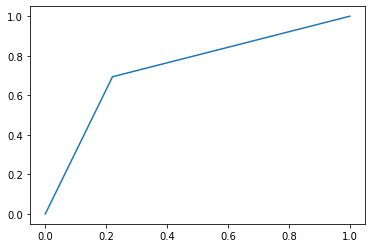

In [100]:
print("Test accuracy: ",Xgb_best.score(x_test, y_test))

y_pred = Xgb_best.predict(x_test)
cm = confusion_matrix(y_test, y_pred.round())
print("Confusion Matrix:", "\n", cm)

tpr, fpr, threshold = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print("AUC Score", auc)

plt.plot(tpr, fpr)
plt.show()

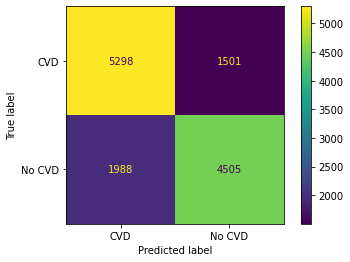

In [106]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(Xgb_best,x_test,y_test,values_format="d",display_labels=["CVD","No CVD"])

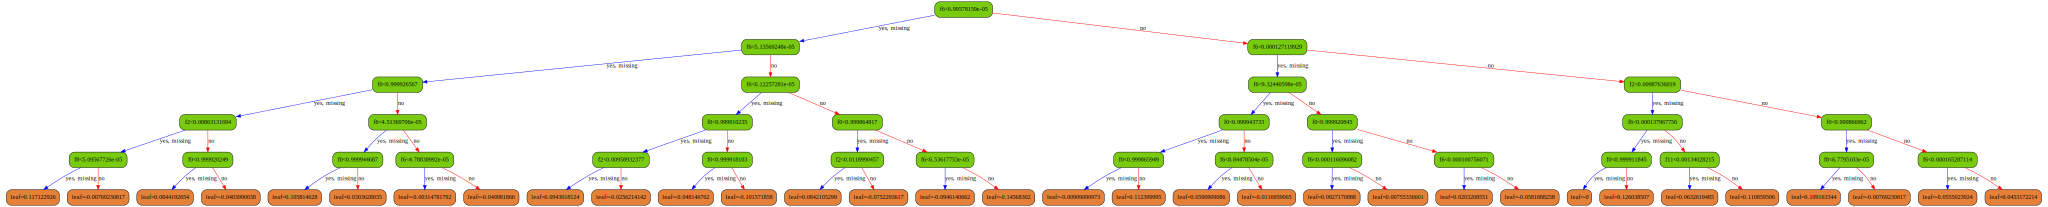

In [112]:
import xgboost as xgb

# bst=Xgb_best.get_booster()
# for importance_type in ("weight" , "gain", "cover", "total_gain", "total_cover"):
#   print('%s: ' % importance_type, bst.get_score(importance_type=importance_type)))
node_params={"shape" : "box",
             "style": "filled,rounded",
             "fillcolor": "#78cbe"}

leaf_params={"shape" : "box",
             "style": "filled,rounded",
             "fillcolor": "#e48038"}

xgb.to_graphviz(Xgb_best,num_trees=0,size="40,40",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)